Calculate time day: 5


[3.98472072e-03 3.98472072e-03 3.98472072e-03 3.98472072e-03
 3.98472072e-03 3.98472072e-03 3.98472072e-03 3.98472072e-03
 3.98472072e-03 3.98472072e-03 3.98472072e-03 3.98472072e-03
 3.98472072e-03 3.98472072e-03 3.98472072e-03 3.98472072e-03
 3.98472072e-03 3.98472072e-03 3.98472072e-03 3.98472072e-03
 3.98472072e-03 9.12846781e-05 9.12846781e-05 9.12846781e-05
 9.12846781e-05 9.12846781e-05 9.12846781e-05 9.12846781e-05
 9.12846781e-05 9.12846781e-05 9.12846781e-05 9.12846781e-05
 9.12846781e-05 9.12846781e-05 9.12846781e-05 9.12846781e-05
 9.12846781e-05 9.12846781e-05 9.12846781e-05 9.12846781e-05
 3.98472072e-03 3.98472072e-03 3.98472072e-03 3.98472072e-03
 3.98472072e-03 3.98472072e-03 3.98472072e-03 3.98472072e-03
 3.98472072e-03 3.98472072e-03 3.98472072e-03 3.98472072e-03
 3.98472072e-03 3.98472072e-03 3.98472072e-03 3.98472072e-03
 3.98472072e-03 3.98472072e-03 3.98472072e-03 3.98472072e-03
 3.98472072e-03]


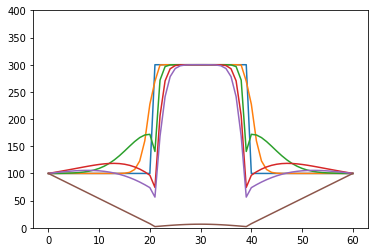

In [4]:
# -*- coding: utf-8 -*-
import numba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fractions import Fraction
from decimal import Decimal


# read excel file and generate lists
def read_data(filename):
    data = pd.read_excel(filename)
    distance = data['distance'].values
    XAn = 0.01*data['An'].values
    iniMg = data['Mg'].values
    return distance, XAn, iniMg

"""
# calcurate diffusion coefficient
def diffuscoef( XAn, TempC ):
    D = np.exp( - 6.06 - 7.9 * XAn - 287000 / ( 8.31 * ( TempC + 273 ) )  )
    return D
"""

def diffuscoef( XAn, TempC ):
    D = ( 2.92 * 10**(-4.1*XAn-3.1) ) * np.exp( -266000 / ( 8.31 * ( TempC + 273 ) ) ) * 10 ** (12)

    return D


# simulate diffusion in mineral
def simulation_ini( iniMg, nt, nx ):
    c = np.zeros( ( nt, nx ) )
    c[0,:] = iniMg
    c[:,0] = iniMg[0]
    c[:,nx-1] = iniMg[nx-1]
    return c


@numba.jit(nopython=True)
def simulation_diffusion( TempC, distance, c, XAn, nt, nx, dt, dx, D ):
    r = D * dt / (dx**2)
    print(r)
    for i in range(nt-1):
        for j in range(1, nx-1):
            c[i+1,j] = c[i,j] + r[j] * ( 4 * ( c[i,j+1] - 2 * c[i,j] + c[i,j-1] ) \
            + ( D[j+1] - D[j-1] ) * ( c[i,j+1] - c[i,j-1] ) ) \
            - ( - 26100 / ( 8.31 * ( TempC + 273 ) ) ) * ( dt / (4 * dx**2) ) \
            * ( D[j] * ( c[i, j+1] - c[i, j-1] ) * ( XAn[j+1] - XAn[j-1] ) \
            + c[i,j] * ( D[j+1] - D[j-1] ) * ( XAn[j+1] - XAn[j-1] ) \
            + 4 * D[j] * c[i,j] * ( XAn[j+1] - 2 * XAn[j] + XAn[j-1] ) )
            
    return c

def plotgraph(distance, c):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in [0, 100, 1000, 3000, 5000, -1]:
        ax.plot(distance, c[i])
        ax.set_ylim(0, 400)
    plt.show()


def main():
    # read excel file
    filename = 'data.xlsx'

    TempC = 1100
    tinput = float(input('Calculate time day:'))

    distance, XAn, iniMg = read_data(filename)
    nx = len(distance)
    #dx = 1*10**(-6)
    dx = 1
    t = 60*60*24*tinput
    dt = 1
    
    D = diffuscoef( XAn, TempC )
    
    nt = int( t / dt )
    c = simulation_ini( iniMg, nt, nx )
    c = simulation_diffusion( TempC, distance, c, XAn, nt, nx, dt, dx, D )
    # save array
    np.save('test', c)
    plotgraph(distance, c)


if __name__ == '__main__':
    main()